https://medium.com/swlh/how-to-apply-machine-learning-in-demand-forecasting-for-retail-b781957e5919

# Importing libraries and cleaned dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import holidays 

In [2]:
# Disabling a specific type of warning from Jupyter, that I know if mistaken for something else
pd.options.mode.chained_assignment = None 

**Original Dataset**:

Chen,Daqing. (2015). Online Retail. UCI Machine Learning Repository. https://archive.ics.uci.edu/dataset/352/online+retail

In [3]:
# Importing the cleaned dataset from my first notebook
file_path = '../data/data_cleaned.csv'
df = pd.read_csv(file_path, dtype={'CustomerID': 'Int64'}, parse_dates=['InvoiceDate'])

# Feature Engineering

**Q's:**

- Outliers?? There were 2 at the first notebook, what to do with them?
- Shall I do the forecast to the top 50 products? or what else?
- Add also a category/product type column?? with 5-6 categories from NLP model?

In [21]:
# inventory, item stock, prediction for inventory
# f.e. next month how we will sell from each item

# top most selling products
# top most high selling products

In [4]:
# maybe first a model to seperate retail to wholesale customers?
# then model to find category of products
# and then model to do inventory forecast?

In [5]:
# no missing records in the time-series model
# consecutive days - datetimeformat
# date column as index!!
# Multi-series forecasting, arima

# model prophet- from meta -> i can specify country

### Focus on UK orders

I am gonna train my model for UK orders. UK orders are more than 90% of the total orders amount, and I want to be able to make more precise predictions, since every country can have different holidays, characteristics, seasons etc.

In [6]:
# Calculating the percentage of total sales per country to all sales
df.groupby('Country')['UnitPrice'].agg(lambda x: 100 * sum(x)/ df.UnitPrice.sum()).sort_values(ascending=False).head()

Country
United Kingdom    91.780509
Ireland            1.601866
Germany            1.592100
France             1.401734
Spain              0.484334
Name: UnitPrice, dtype: float64

In [7]:
df = df[df.Country == 'United Kingdom']

# Dropping the Country column
df.drop(columns=['Country'], inplace=True)

### Removing outliers

In [8]:
df.sort_values(by='Quantity', ascending=False).head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
523082,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446
59607,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346
407971,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2011-10-27 12:26:00,0.21,12901
199262,554868,22197,POPCORN HOLDER,4300,2011-05-27 10:52:00,0.72,13135
94150,544612,22053,EMPIRE DESIGN ROSETTE,3906,2011-02-22 10:43:00,0.82,18087


In [9]:
df = df[~df.InvoiceNo.isin([581483,541431])]

**And what about these outliers ???**

In some cases, outliers may contain valuable information about changes in the underlying process. I need to figure out if I am gonna keep them, or f.e. transform the data.

<Axes: ylabel='Quantity'>

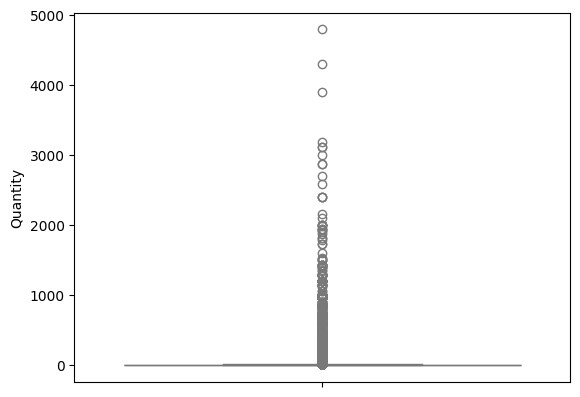

In [10]:
sns.boxplot(data = df['Quantity'], color="lightblue") # there are outliers

### Removing features that will not be used

I will be using Invoice number and Customer ID for my model. Also removing the shipping costs, as they will not be part of the model.

In [11]:
# Dropping the columns InvoiceNo and CustomerID
df.drop(columns=['InvoiceNo','CustomerID'], inplace=True)

# Dropping the shipping costs
df = df[~df.StockCode.str.contains('SHIPPING')]

### Date column

Adding new columsn for year/month/day, also for weekday/weekend and UK holidays.

In [12]:
# New date column without time
df['InvoiceDate_noTime'] = df.InvoiceDate.dt.normalize()

# New columns for year/month/day
df[['Year','Month','Day']] = df.InvoiceDate.dt.strftime('%Y-%m-%d').str.split('-', n=3, expand=True)

# Defining if it is weekday or weekend
df['Weekend'] = (df['InvoiceDate'].dt.dayofweek > 4).astype(int)

# Finding holidays in UK
# Currently all are False, cause in the date of holidays the online store was possibly closed
#uk_holidays = holidays.UnitedKingdom() 
#df['Holidays'] = df['InvoiceDate_noTime'].isin(uk_holidays).astype(int)

### Total product amount

Adding a new column for the total amount for each StockCode of the order.

In [13]:
df['TotalPrice'] = df.Quantity * df.UnitPrice

# EDA

### Quantity sold for all products

<Axes: xlabel='InvoiceDate_noTime'>

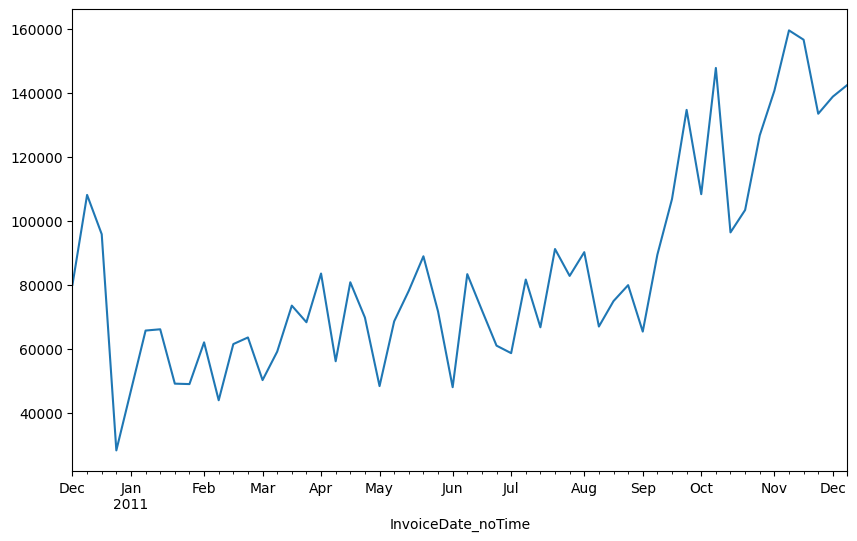

In [14]:
# per week
df.groupby(df['InvoiceDate_noTime'].dt.to_period('W'))['Quantity'].sum().plot(figsize=(10, 6))

<Axes: xlabel='InvoiceDate_noTime'>

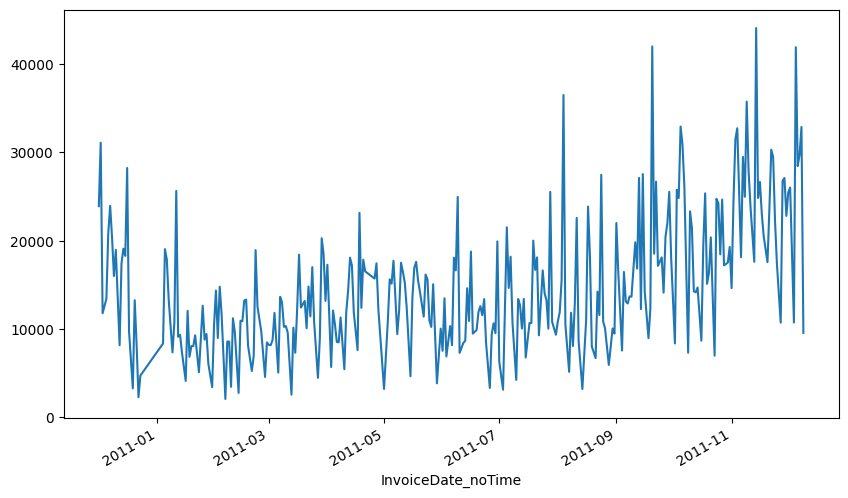

In [15]:
# per day
df.groupby('InvoiceDate_noTime')['Quantity'].sum().plot(figsize=(10, 6))

### Quantity sold for the top selling products

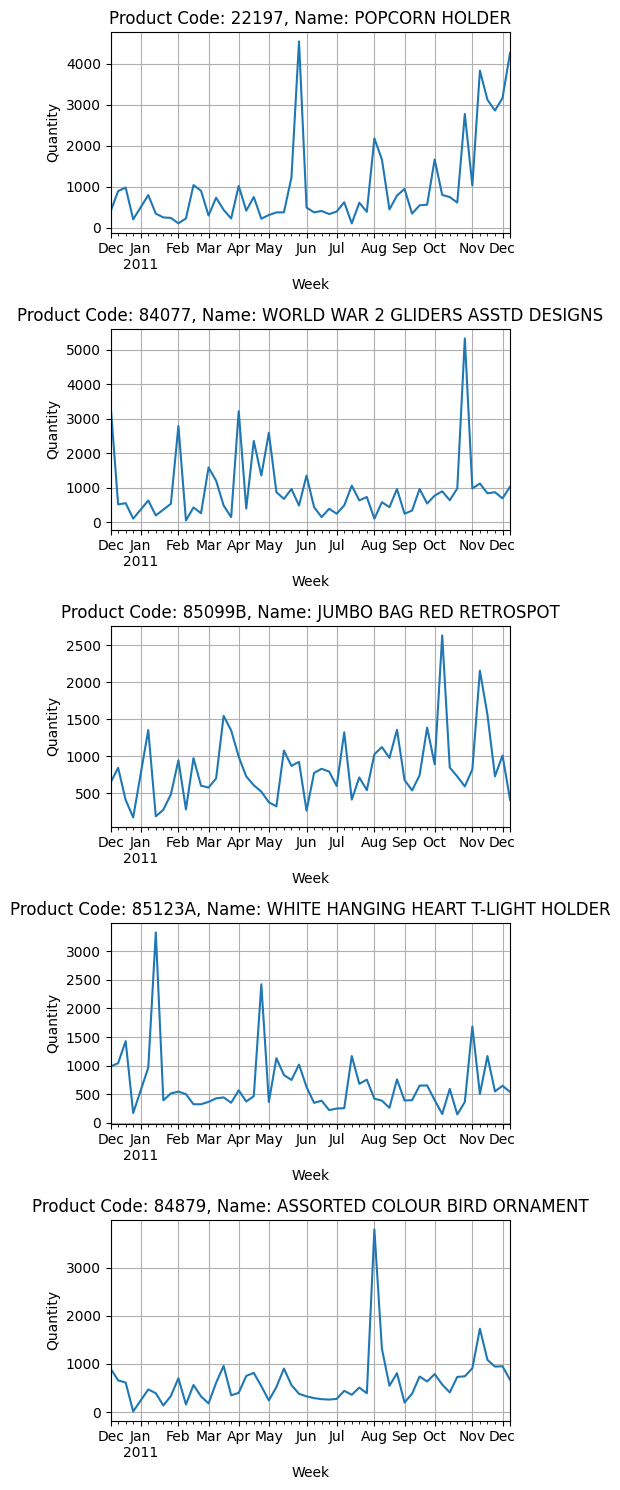

In [16]:
# List of product codes to plot
product_codes = ['22197','84077','85099B','85123A','84879' ]

# Create subplots
fig, axes = plt.subplots(len(product_codes), 1, figsize=(5, 3 * len(product_codes)))

# Iterate over each product code
for i, code in enumerate(product_codes):
    # Filter DataFrame for the current product code
    df_product = df[df['StockCode'] == code]
    
    # Group by week and calculate total sales, plot total sales per (week/day) for the current product code
    ax = df_product.groupby(df_product['InvoiceDate_noTime'].dt.to_period('W'))['Quantity'].sum().plot(ax=axes[i])
    #ax = df_product.groupby(df_product['InvoiceDate_noTime'])['TotalPrice'].sum().plot(ax=axes[i])
    ax.set_title(f"Product Code: {code}, Name: {df[df['StockCode'] == code].Description.mode()[0]}")
    ax.set_ylabel("Quantity")
    ax.set_xlabel("Week")
    ax.grid(True)

# Adjust layout and spacing
plt.tight_layout()
plt.show()

### Top selling products and unit price

In [17]:
# Making a list with the StockCodes of the top 10 selling products
#top_10_stock = df.groupby('StockCode')['TotalPrice'].sum().sort_values(ascending=False).head(10).index.tolist()

In [18]:
df.groupby('StockCode')['UnitPrice'].nunique().sort_values(ascending=False) # Products appear with more than 1 prices

StockCode
79321     15
21166     14
47566     14
21175     13
20685     13
          ..
72802a     1
21445      1
72801c     1
21416      1
47579      1
Name: UnitPrice, Length: 3908, dtype: int64

In [19]:
df_quantity = df.groupby('StockCode')['Quantity'].sum().reset_index()
df_quantity = df_quantity.merge(df.groupby('StockCode')['UnitPrice'].agg(lambda x: x.mode()[0]), how='inner', on='StockCode')
df_quantity

,StockCode,Quantity,UnitPrice
0,10002,438,0.85
1,10080,303,0.39
2,10120,182,0.21
3,10123C,5,0.65
4,10124A,16,0.42
...,...,...,...
3903,gift_0001_10,9,8.33
3904,gift_0001_20,10,16.67
3905,gift_0001_30,7,25.00
3906,gift_0001_40,3,33.33


<Axes: xlabel='Quantity', ylabel='UnitPrice'>

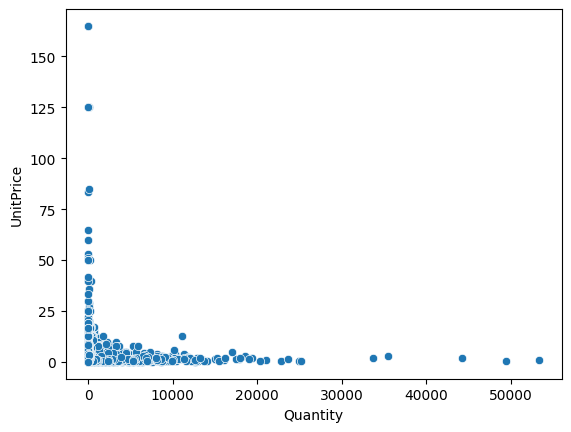

In [20]:
sns.scatterplot(data=df_quantity, x='Quantity', y='UnitPrice')